In [2]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')
    !pip install torchaudio
    !pip install wandb --upgrade
    # !wandb login
    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews
    !pip install -U ipykernel
    !pip install joypy
    # !pip install umap-learn
    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Results')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Figures')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Result')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics/Jaguas"
    root_path = "media/mirp_ai/Seagate Desktop Drive/Jaguas_2018"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [3]:
# from __future__ import print_function
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import gc
import pandas as pd
import joypy

from scipy import signal
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torchaudio.transforms as audio_transform


#from ResidualStack import ResidualStack
#from Residual import Residual

from Jaguas_DataLoader_rainless import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = xm.xla_device()

from datetime import timedelta
import wandb
from wandb import AlertLevel

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import pickle as pkl

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

# AE Model

In [4]:
model_type = "AE"
identifier = "batch_size_14_num_hiddens_64_"
day = 9
hour = 4
month = 6
folder = "AE_rain"
date_format = f"day_{day}_hour_{hour}"

model_name = f"{root}/temporal/models/model_{model_type}_{identifier}_{date_format}_final.pth"
config = torch.load(f'temporal/configs/config_{model_type}_{identifier}_{date_format}.pth', map_location=torch.device('cpu'))
model = AE(num_hiddens=config["num_hiddens"]).to(device)
# dataset_test = torch.load(f'temporal/datasets/dataset_test_ae_jaguas_9_70%.pth')
# dataset_train = torch.load(f'temporal/datasets/dataset_train_ae_jaguas_9_70%.pth')
model.load_state_dict(torch.load(f'{model_name}', map_location=torch.device('cpu')))

y = torch.load(f"temporal/Features/{folder}/AE_labels_{date_format}_rain_Audios_Jaguas.pth",  map_location=torch.device('cpu'))
X = torch.load(f"temporal/Features/{folder}/AE_features_{date_format}_rain_Audios_Jaguas.pth",  map_location=torch.device('cpu'))
path = torch.load(f"temporal/Features/{folder}/AE_test_path_samples_{date_format}_rain_Audios_Jaguas.pth",  map_location=torch.device('cpu'))
path_flat = [item for sublist in path for item in sublist]
path_flat = np.asarray(path_flat)
print(X.shape)
y["recorder"]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
Normalizer_ = Normalizer().fit(X)
X_norm = Normalizer_.transform(X)
PCA_ = PCA(n_components=30).fit(X_norm)
X_PCA = PCA_.transform(X_norm)
# X_TSNE = TSNE(n_components=2, learning_rate="auto", init='random', random_state=0).fit_transform(X_PCA)
reducer = umap.UMAP(min_dist=0.9)
X_UMAP = reducer.fit_transform(X_PCA)
# X_UMAP_Norm = Normalizer().fit_transform(X_UMAP)


torch.Size([100335, 5184])


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.



# POSAE Model

from Models import PositionalEncoding2d
from Models import posautoencoding_m1
from sklearn.decomposition import PCA

model = "PositionalAE_hour"
identifier = "batch_size_14_num_hiddens_64_"
day = 29
hour = 9
month = 6
folder = "PosAE_Hour_No_rain"
date_format = f"month_{month}_day_{day}_hour_{hour}"
model_name = f"{root}/temporal/models/model_{model}_{identifier}_{date_format}_final.pth"
config = torch.load(f'{root}/temporal/configs/config_{model}_{identifier}_{date_format}.pth', map_location=torch.device('cpu'))
model = AE(num_hiddens=config["num_hiddens"]).to(device)
# dataset_test = torch.load(f'temporal/datasets/dataset_test_ae_jaguas_9_70%.pth')
# dataset_train = torch.load(f'temporal/datasets/dataset_train_ae_jaguas_9_70%.pth')
model.load_state_dict(torch.load(f'{model_name}', map_location=torch.device('cpu')))

y = torch.load(f"temporal/Features/{folder}/PosAE_labels_{date_format}_No_rain_Audios_Jaguas.pth",  map_location=torch.device('cpu'))
X = torch.load(f"temporal/Features/{folder}/PosAE_features_{date_format}_No_rain_Audios_Jaguas.pth",  map_location=torch.device('cpu'))
path = torch.load(f"temporal/Features/{folder}/PosAE_test_path_samples_{date_format}_No_rain_Audios_Jaguas.pth")
path_flat = [item for sublist in path for item in sublist]
path_flat = np.asarray(path_flat)
print(X.shape)
y["recorder"]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_norm = Normalizer().fit_transform(X)
PCA_ = PCA(n_components=30).fit(X_norm)
X_PCA = PCA_.transform(X_norm)
X_TSNE = TSNE(n_components=2, learning_rate="auto", init='random', random_state=0).fit_transform(X_PCA)
reducer = umap.UMAP(min_dist=0.9)
X_UMAP = reducer.fit_transform(X)
X_UMAP_Norm = Normalizer().fit_transform(X_UMAP)

In [5]:
# filters = {"Intensity_Category": "No_rain"}
dataset = SoundscapeData(root_path, dataframe_path="Complementary_Files/Audios_Jaguas/Audios_Jaguas.csv",
                         audio_length=12, ext="wav",
                         win_length=1028)#, filters=filters)
test_loader = DataLoader(dataset, batch_size=100)
iterator = iter(test_loader)
testing = TestModel(model, iterator, device=torch.device("cuda"))

/media/mirp_ai/Seagate Desktop Drive/Jaguas_2018


## **Batch Clustering**

In [ ]:
clusters = [3, 4, 5, 6, 7, 8, 9, 10, 15, 18, 20, 25, 30 ]
for n_cluster in clusters:
    print(f"current cluster: {n_cluster}")
    iterator_Dataset = iter(training_loader)
    testing = TestModel(model, iterator_Dataset, device=torch.device("cuda"))
    Clustering = AE_Clustering(testing, training_loader, n_clusters=n_cluster)
    kmeans = Clustering.fordward()
    # Clustering.plot_centroids()
    output.clear()

In [ ]:
Clustering.plot_centroids()
plt.savefig(f"Clustering_Results/Figures/Clustering_centroids_TSNE_7.pdf", format="pdf")

## **Traditional clustering**

In [6]:
# Batch methods
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
import matplotlib.cm as cm
import math

# Single methods
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics
from sklearn.metrics import silhouette_samples
from Modules.Clustering_Utils import plot_silhouette
from Modules.Clustering_Utils import plot_centroids
from Modules.Clustering_Utils import Clustering_Results

# %matplotlib qt
from logging import raiseExceptions
import librosa
def plot_silhouette( X, cluster_labels, n_clusters, silhouette_avg, method=None, extra=None, save=False):
    fig, ax1 = plt.subplots(figsize=(12, 12))

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0,
                    0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    if save == True:
        plt.savefig(f"temporal/clustering_results/{method}/Silhouette_plot_{n_clusters}_{extra}.pdf", format="pdf")
        plt.show()
    else:
        print("Ploted!")
        pass

def plot_centroids(cluster_centers, model, method, extra="", save=True):
    plt.figure(figsize=(18, 18))
    model._model.to("cpu")
    for i, spec in enumerate(cluster_centers):
        encodings = spec.reshape(64,9,9)
        encodings = torch.tensor(encodings).float()
        decodings = model._model.decoder(encodings).detach().numpy()
        plt.subplot(6, 6, i + 1)
        plt.imshow(decodings[0, :, :], origin="lower", cmap="viridis")
        plt.xticks(())
        plt.yticks(())
    n_cluster = len(cluster_centers)
    if save == True:
        plt.savefig(f"temporal/clustering_results/{method}/Centroids_plot_{n_cluster}_{extra}.pdf", format="pdf")
        plt.show()
    else:
        print("Ploted!")
        pass
    

def num_rows_cols(num_elements):
    num_rows = int(math.sqrt(num_elements))
    num_cols = (num_elements + num_rows - 1) // num_rows
    return (num_rows, num_cols)

def get_row_col(pos, cols):
    row = pos // cols
    col = pos % cols
    return row, col

class Clustering_Results:
    def __init__(self, model, y, y_label="hour", hist_library="plt"):
        self._labels_cluster = None
        self._n_labels = None
        self._label = y_label
        self._model = model
        self._n_clusters = len(set(model.labels_))
        self.y = y
        self._y = self.converter(y[self._label])
        self._n_labels = set(self._y)

    def converter(self, var):
        aux = []
        for i in range(len(var)):
            aux.append(var[i].item())
        return np.array(aux)

    def one_cluster_eval(self, cluster):
        index = np.where(self._model.labels_ == cluster)
        index = list(index[0])
        self._labels_cluster = self._y[index]
        return self._labels_cluster
    
    def tagger(self, samples):
        labels = []
        labels_all_clusters = []
        joy_vars = ["hour", "recorder"]
        for cluster in range(self._n_clusters):
            y_aux = []
            labels_cluster = []
            for i, label in enumerate(joy_vars):
                y_aux.append(self.converter(self.y[label]))
                index = np.where(self._model.labels_ == cluster)
                index = list(index[0])
            labels.append(samples[index])
        return labels

    def joyplot(self):
        labels_all_clusters = []
        size_x = 8
        size_y = 6
        joy_vars = ["hour", "recorder"]
        for cluster in range(self._n_clusters):
            y_aux = []
            labels_cluster = []
            for i, label in enumerate(joy_vars):
                y_aux.append(self.converter(self.y[label]))
                index = np.where(self._model.labels_ == cluster)
                index = list(index[0])
                labels_cluster.append(y_aux[i][index])
            df = pd.DataFrame({'recorder':labels_cluster[0], "hour":labels_cluster[1]})
            if(self._label == "hour"):
                joypy.joyplot(df, by="hour", column="recorder", range_style='own', 
                                grid="y", hist=False, linewidth=1, legend=False, figsize=(size_x,size_y),
                                title=f"Cluster {cluster} \nLabels distribution along recorders using recorders as rows",
                                colormap=cm.autumn_r, fade=False)
                plt.xticks(np.arange(0,24),fontsize=20)
                plt.yticks(fontsize=11)
                
#             plt.fontsize(11)
            elif(self._label == "recorder"):
                joypy.joyplot(df, by="recorder", column="hour", range_style='own', 
                                    grid="y", hist=False, linewidth=1, legend=False, figsize=(size_x,size_y),
                                    title=f"Cluster {cluster} \nLabels distribution along recorders using hours as rows",
                                    colormap=cm.autumn_r)

#             plt.yticks(fontsize=22)
            labels_all_clusters.append(index)
            plt.show()
#             print(len(labels_cluster))
#             print(labels_cluster[1].shape)
#             print(labels_cluster[0:10])
#             print(index[0:20])
        
#         return labels_all_clusters
            

    def histograms(self, hist_library="plt", method=None, root=None):
        bins = list(self._n_labels)
        print(bins)
        num_rows, num_cols = num_rows_cols(self._n_clusters)
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 14))
        if self._n_clusters <= 3:
                axes = np.expand_dims(axes,0)
                fig.set_figheight(6)
                fig.set_figwidth(12)
                if self._n_clusters == 1:
                    axes = np.expand_dims(axes,0)
                else:
                    pass
        else:
            pass
        for hist in range(self._n_clusters):
            aux = self.one_cluster_eval(hist)
            ax_0, ax_1 = get_row_col(hist, num_cols)
            if hist_library == "plt":
                axes[ax_0][ax_1].hist(aux, histtype="bar",
                                      color="paleturquoise", cumulative=False,
                                      edgecolor='black', 
                                      linewidth=1.2, bins=bins, stacked=False)
                axes[ax_0][ax_1].set_title(f"Cluster: {hist}", size=16)
            elif hist_library == "sns":
                sns.distplot(aux,bins=np.arange(aux.min(), aux.max()+1),
                             hist_kws=dict(edgecolor="black", linewidth=1), 
                             ax=axes[ax_0, ax_1])
                axes[ax_0][ax_1].set_title(f"Cluster: {hist}", size=16)              
            else:
                raise Exception(f"Library {self._hist_library} unused")
                
            if root != None:
                plt.savefig(f"temporal/clustering_results/{method}/Histograms_plot_{self._n_clusters}.pdf", format="pdf")
            else:
                pass
        plt.show()

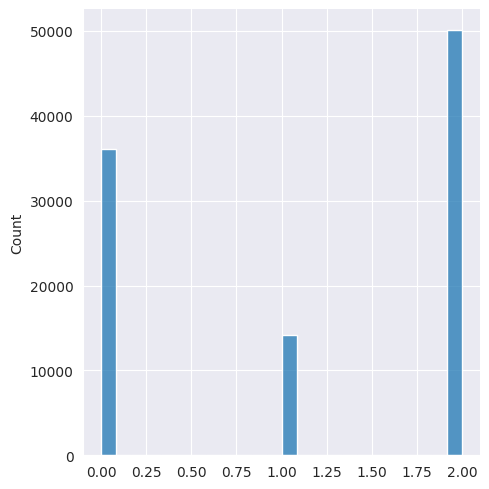

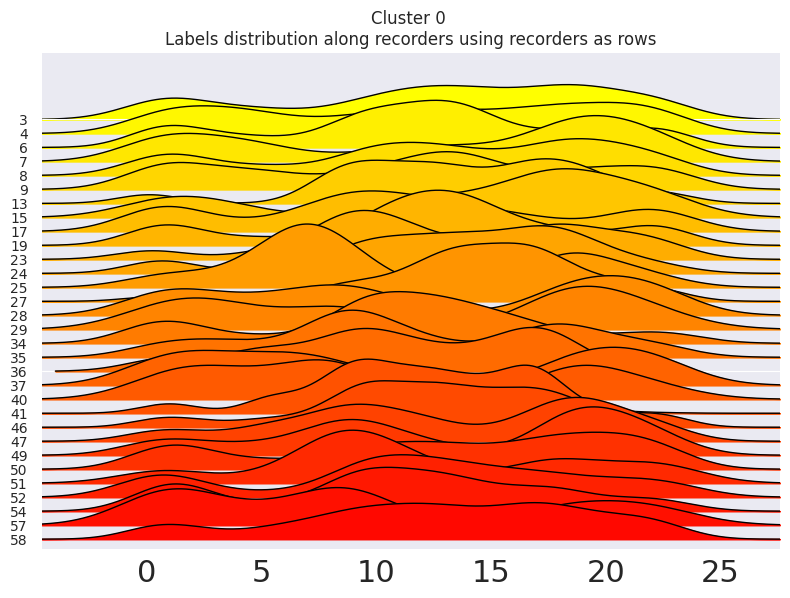

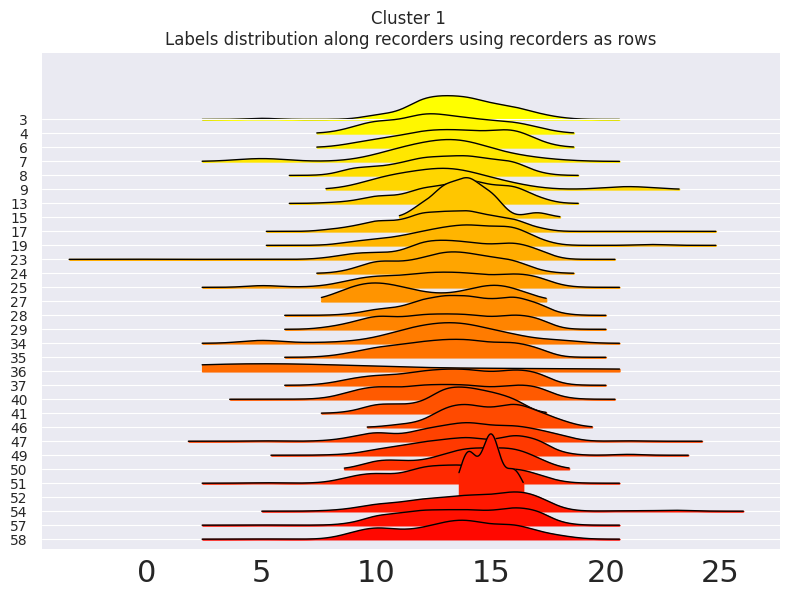

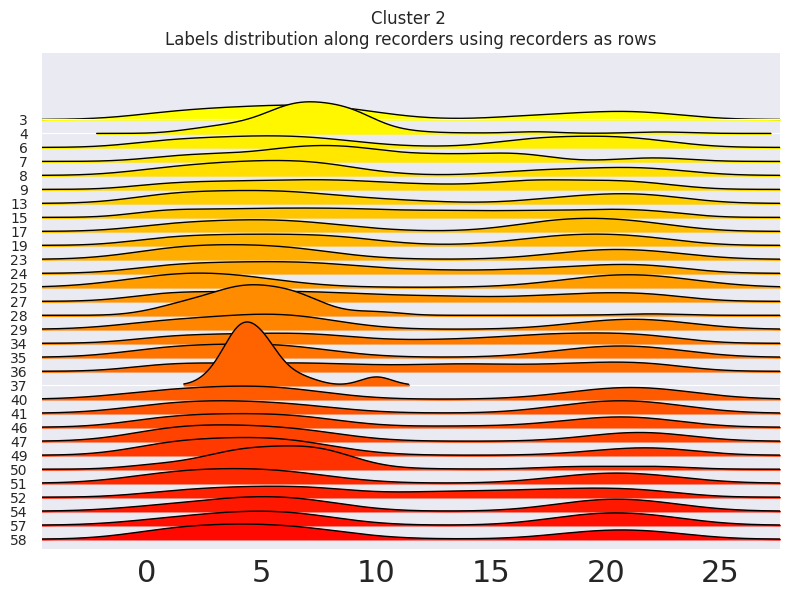

[[75,
  76,
  77,
  84,
  85,
  86,
  87,
  88,
  95,
  96,
  101,
  102,
  109,
  110,
  117,
  120,
  121,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  148,
  149,
  170,
  171,
  172,
  173,
  194,
  204,
  220,
  221,
  222,
  223,
  224,
  245,
  249,
  285,
  286,
  287,
  288,
  289,
  290,
  291,
  292,
  293,
  294,
  295,
  296,
  297,
  298,
  299,
  300,
  301,
  303,
  304,
  311,
  312,
  436,
  437,
  438,
  439,
  440,
  441,
  442,
  443,
  445,
  446,
  447,
  448,
  460,
  461,
  462,
  463,
  464,
  465,
  466,
  467,
  468,
  473,
  476,
  477,
  478,
  479,
  480,
  481,
  482,
  483,
  484,
  485,
  486,
  487,
  488,
  489,
  490,
  491,
  492,
  493,
  494,
  495,
  496,
  497,
  498,
  499,
  500,
  501,
  502,
  503,
  504,
  505,
  506,
  507,
  508,
  509,
  510,
  511,
  512,
  513,
  514,
  515,
  516,
  517,
  518,
  519,
  520,
  521,
  522,
  523,
  524,
  525,
  526,
  527,
  528,
  529,
  530,
  531,
  532,
  533,
  534,
  535,
  536,
  537,
  

In [7]:
from sklearn.cluster import KMeans
Kmeans = KMeans(n_clusters=3, random_state=0).fit(X_norm)
import warnings
warnings.filterwarnings("ignore")
Kmeans_Results = Clustering_Results(Kmeans, y, y_label="hour")
sns.displot(Kmeans.labels_)
# Kmeans_Results.histograms(hist_library="sns")
# Kmeans_Results.histograms(method="Kmeans", root="temporal/clustering_results/Kmeans/")
Kmeans_Results.joyplot()

In [ ]:
f = Kmeans_Results.tagger(path_flat)
torch.save(f,f"temporal/clusters/kmeans_UMAP_clustering_labels_PosAE_rainless_{len(set(Kmeans.labels_))}")

In [ ]:
leido= torch.load(f"Features/clustering_labels_clusters_3")

In [ ]:
len(leido[2])

In [ ]:
import warnings
warnings.filterwarnings("ignore")
Kmeans_Results = Clustering_Results(Kmeans, y, y_label="hour", hist_library="plt")
Kmeans_Results.histograms()

## Kmeans

In [ ]:
Kmeans_Results.joyplot()

In [ ]:
clusters = [3]
# mean = X.mean()
# std = X.std()
for id, n_cluster in enumerate(clusters):
    Kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(X_norm)
    silhouette_score_Kmeans = metrics.silhouette_score(X_norm, Kmeans.labels_)
    plot_silhouette(X_norm, Kmeans.labels_, Kmeans.n_clusters, silhouette_score_Kmeans, method=f"Kmeans", save=True)
    cluster_centers = Normalizer_.inverse_transform(Kmeans.cluster_centers_)
    plot_centroids(cluster_centers, testing, method="Kmeans", save=False)
    Kmeans_Results = Clustering_Results(Kmeans, y, y_label="hour", hist_library="plt")
    Kmeans_Results.histograms(method="Kmeans")#, root="temporal/clustering_results/Kmeans/")
    Kmeans_Results.joyplot()
#     with open(f"temporal/clustering_results/Kmeans/silhouette_n-clusters_{Kmeans.n_clusters}", "wb") as file:
#         pkl.dump(silhouette_score_Kmeans, file)

## Kmeans PCA

In [ ]:
for id, n_cluster in enumerate(clusters):
    Kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(X_PCA)
    silhouette_score_Kmeans = metrics.silhouette_score(X_PCA, Kmeans.labels_)
    plot_silhouette(X_PCA, Kmeans.labels_, Kmeans.n_clusters, silhouette_score_Kmeans, "Kmeans_PCA", save=True)
    Kmeans_Results = Clustering_Results(Kmeans, y, y_label="hour", hist_library="plt")
    Kmeans_Results.histograms(method="Kmeans_PCA", root="temporal/clustering_results/Kmeans_PCA/")
#     Kmeans_Results.joyplot()
    cluster_centers = PCA_.inverse_transform(Kmeans.cluster_centers_)
    plot_centroids(cluster_centers, testing, method="Kmeans_PCA")
    with open(f"temporal/clustering_results/Kmeans_PCA/PCA_silhouette_n-clusters_{Kmeans.n_clusters}", "wb") as file:
        pkl.dump(silhouette_score_Kmeans, file)

## Kmeans TSNE


In [ ]:
for id, n_cluster in enumerate(clusters):
    Kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(X_TSNE)
    silhouette_score_Kmeans = metrics.silhouette_score(X_TSNE, Kmeans.labels_)
    plot_silhouette(X_TSNE, Kmeans.labels_, Kmeans.n_clusters, silhouette_score_Kmeans, method=f"{model_name}_Kmeans_TSNE", save=True)
    Kmeans_Results = Clustering_Results(Kmeans, y, y_label="hour", hist_library="plt")
    Kmeans_Results.histograms(method=f"{model_name}_Kmeans_TSNE", root=f"temporal/clustering_results/{model_name}_Kmeans_TSNE/")
#     Kmeans_Results.joyplot()
#     cluster_centers = reducer.inverse_transform(Kmeans.cluster_centers_)
#     plot_centroids(cluster_centers, testing, method="PosAE_Kmeans_TSNE")
    with open(f"temporal/clustering_results/{model_name}_Kmeans_TSNE/TSNE_silhouette_n-clusters_{Kmeans.n_clusters}", "wb") as file:
        pkl.dump(silhouette_score_Kmeans, file)

## Kmeans UMAP

In [ ]:
for id, n_cluster in enumerate(clusters):
    Kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(X_UMAP)
    silhouette_score_Kmeans = metrics.silhouette_score(X_UMAP, Kmeans.labels_)
    plot_silhouette(X_UMAP, Kmeans.labels_, Kmeans.n_clusters, silhouette_score_Kmeans, method=f"{model_name}_Kmeans_UMAP", save=True)
    Kmeans_Results = Clustering_Results(Kmeans, y, y_label="hour", hist_library="plt")
    Kmeans_Results.histograms(method=f"{model_name}_Kmeans_UMAP", root=f"temporal/clustering_results/{model_name}_Kmeans_UMAP/")
#     Kmeans_Results.joyplot()
    cluster_centers = reducer.inverse_transform(Kmeans.cluster_centers_)
    plot_centroids(cluster_centers, testing, method=f"{model_name}_Kmeans_UMAP")
    with open(f"temporal/clustering_results/{model_name}_Kmeans_UMAP/UMAP_silhouette_n-clusters_{Kmeans.n_clusters}", "wb") as file:
        pkl.dump(silhouette_score_Kmeans, file)

In [ ]:
class Unsupervised_AutoML:
    def __init__(self, estimators=None, transformers=None):
        self.estimators = estimators
        self.transformers = transformers
        pass

    def fit_predict(self, X, y=None):
        """
        fit_predict will train given estimator(s) and predict cluster membership for each sample
        """

        # This dictionary will hold predictions for each estimator
        predictions = []
        performance_metrics = {}

        for estimator in self.estimators:
            labels = estimator['estimator'](*estimator['args'], **estimator['kwargs']).fit_predict(X)
            estimator['estimator'].n_clusters_ = len(np.unique(labels))
            metrics = self._get_cluster_metrics(estimator['estimator'].__name__, estimator['estimator'].n_clusters_, X, labels, y)
            predictions.append({estimator['estimator'].__name__: labels})
            performance_metrics[estimator['estimator'].__name__] = metrics

            self.predictions = predictions
            self.performance_metrics = performance_metrics

            return predictions, performance_metrics

    # Printing cluster metrics for given arguments
    def _get_cluster_metrics(self, name, n_clusters_, X, pred_labels, true_labels=None):
        from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score,  adjusted_mutual_info_score, silhouette_score  
           
        print("""################## %s metrics #####################""" % name)
        if len(np.unique(pred_labels)) >= 2:

            silh_co = silhouette_score(X, pred_labels)

        if true_labels is not None:

            h_score = homogeneity_score(true_labels, pred_labels)
            c_score = completeness_score(true_labels, pred_labels)
            vm_score = v_measure_score(true_labels, pred_labels)
            adj_r_score = adjusted_rand_score(true_labels, pred_labels)
            adj_mut_info_score = adjusted_mutual_info_score(true_labels, pred_labels)

            metrics = {"Silhouette Coefficient": silh_co,
            "Estimated number of clusters": n_clusters_,
            "Homogeneity": h_score,
            "Completeness": c_score,
            "V-measure": vm_score,
            "Adjusted Rand Index": adj_r_score,
            "Adjusted Mutual Information": adj_mut_info_score}
        
            for k, v in metrics.items():
                print("t%s: %0.3f" % (k, v))

            return metrics

        metrics = {"Silhouette Coefficient": silh_co,
        "Estimated number of clusters": n_clusters_}

        for k, v in metrics.items():
            print("t%s: %0.3f" % (k, v))

        else:
            print("t# of predicted labels is {}, can not produce metrics. n".format(np.unique(pred_labels)))
            
        return metrics
        

## DBSCAN

In [ ]:
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
classes = []
silhouette_score_DBSCAN = []
i = 1
EPS = [0.01, 0.1, 0.5, 1, 10, 20, 36, 50, 80, 100]
for x in range(0, 9, 1):
    eps = EPS[x]
    db = DBSCAN(eps=eps, min_samples=4).fit(X_scaled)
    # silhouette_score_DBSCAN.append(metrics.silhouette_score(X_PCA, db.labels_))
    # plot_silhouette(X_PCA, db.labels_, 15, silhouette_score_DBSCAN[i-1], "DBSCAN_PCA")
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    print(eps)
    ax = fig.add_subplot(3, 3, i)
    ax.text(1, 4, "eps = {}".format(round(eps, 1)), fontsize=25, ha="center")
    sns.scatterplot(X_scaled[:,0], X_scaled[:,1], hue=["cluster-{}".format(x) for x in labels]) 
    i += 1

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    Kmeans_Results = Clustering_Results(db, y, y_label="hour", hist_library="plt")
    Kmeans_Results.histograms()

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
with open(f"Clustering_Results/DBSCAN/Results/silhouette_n-clusters_{n_clusters_}", "wb") as file:
    pkl.dump(silhouette_score_DBSCAN, file)


In [ ]:
db = DBSCAN(eps=0.8, min_samples=100).fit(X_norm)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
metrics.silhouette_score(X_scaled, db.labels_)
sns.displot(db.labels_)

## DBSCAN PCA

In [ ]:
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
classes = []
silhouette_score_DBSCAN = []
i = 1
EPS = [0.01, 0.1, 0.5, 1, 10, 20, 36, 50, 80, 100]
for eps in EPS:
    db = DBSCAN(eps=eps, min_samples=4).fit(X_PCA)
    # silhouette_score_DBSCAN.append(metrics.silhouette_score(X_PCA, db.labels_))
    # plot_silhouette(X_PCA, db.labels_, 15, silhouette_score_DBSCAN[i-1], "DBSCAN_PCA")
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    print(eps)
    ax = fig.add_subplot(5, 5, i)
    ax.text(1, 4, "eps = {}".format(round(eps, 1)), fontsize=25, ha="center")
    sns.scatterplot(X_PCA[:,0], X_PCA[:,1], hue=["cluster-{}".format(x) for x in labels]) 
    i += 1

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)

    Kmeans_Results = Clustering_Results(db, y, y_label="hour", hist_library="plt")
    Kmeans_Results.histograms()
with open(f"Clustering_Results/DBSCAN_PCA/Results/silhouette_n-clusters_{n_clusters_}", "wb") as file:
    pkl.dump(silhouette_score_DBSCAN, file)


In [ ]:
!pip install kneed
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=10)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances[:,9], axis=0)

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig2 = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(f"The knee is located at: {distances[knee.knee]}")

In [ ]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=12,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=1,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [ ]:
linkage = "complete"
connectivity = False
model = AgglomerativeClustering(
                linkage=linkage, connectivity=connectivity, 
                n_clusters=3)
model.fit(X_PCA)

In [5]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
# X = np.array([[1, 2], [1, 4], [1, 0],
#                   [4, 2], [4, 4], [4, 0]])
clustering = AgglomerativeClustering().fit(X_UMAP)
n_clusters_ = len(set(clustering.labels_))
print(n_clusters_)
print(list(clustering.labels_).count(1))


2
53178


In [6]:
print(list(clustering.labels_).count(1))


47157


In [7]:
Kmeans_Results = Clustering_Results(clustering, y, y_label="hour")
sns.displot(clustering.labels_)
Kmeans_Results.histograms(hist_library="sns")

NameError: name 'Clustering_Results' is not defined

In [23]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

complete_clustering = linkage(X_UMAP, method="complete", metric="euclidean")
average_clustering = linkage(X_UMAP, method="average", metric="euclidean")
single_clustering = linkage(X_UMAP, method="single", metric="euclidean")
complete_clustering_labels = fcluster(complete_clustering,t=5,criterion="maxclust")

In [22]:
set(complete_clustering_labels)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [9]:
%matplotlib qt
dendrogram(complete_clustering)
plt.show()

In [10]:
# %matplotlib qt
dendrogram(average_clustering)
plt.show()

In [11]:
%matplotlib qt
dendrogram(single_clustering)
plt.show()

RecursionError: maximum recursion depth exceeded while getting the str of an object